In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from scipy.stats import shapiro, normaltest
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from lightgbm import LGBMRegressor



In [3]:
#Load data
df = pd.read_csv("../data/training_data.csv")
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,432.475954,289.373016,481.315600,358.755566,802.659004,176.761177,72.648102,720.969179,36.327684,83.768878,...,4.385848,516.789458,19.624422,13.162440,42.351948,35.920392,20.755984,13.814300,384.497136,14.364922
1,517.596250,330.448341,585.920055,22.684031,169.813240,335.601640,284.451476,748.101047,73.701438,358.147215,...,5.563334,2.960064,20.721878,17.740184,1.726915,167.576065,75.492679,2.480979,303.710869,19.984801
2,189.439350,553.888820,165.833790,202.465927,176.695586,321.155049,407.278389,161.245668,282.269025,221.570899,...,4.536947,581.823741,101.695639,0.653592,486.859084,117.491548,6.420465,20.713314,22.651537,12.944351
3,237.307878,195.894881,416.752252,468.729031,611.693517,301.411711,241.880655,49.597044,122.396821,13.828319,...,5.518968,45.014729,196.350455,47.638515,411.414213,67.142022,115.630943,8.927957,388.240433,14.792440
4,602.845256,16.103208,221.759979,345.765574,558.588369,276.704241,408.069566,19.390813,138.769765,146.662193,...,2.136214,133.590430,197.634584,26.278027,111.127557,172.181136,85.869642,30.537857,625.931837,11.802634


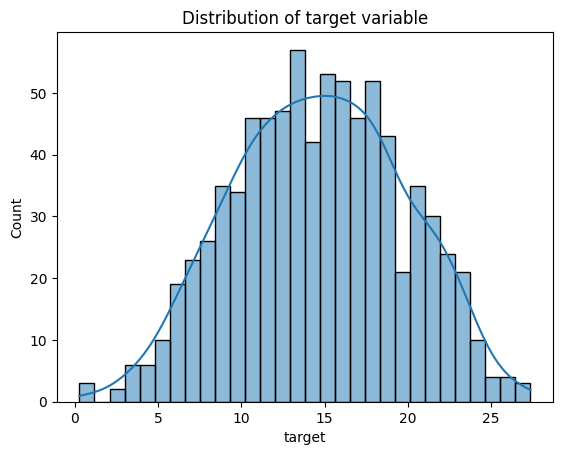

In [67]:
# Distribution of target variable
sns.histplot(df["target"], bins=30, kde=True)
plt.title("Distribution of target variable")
plt.show()

In [68]:
# Shapiro-Wilk test
shapiro_test = shapiro(df["target"])
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

Shapiro-Wilk test: Statistic=0.9943032659789999, p-value=0.0041471902899279925


The target variable appears to be approximately normally distributed, but the Shapiro-Wilk test indicates that it is not. The distribution of the target variable has a slight right skew.

Then, I explored the relationship between the features and the target variable, I created scatter plots for each predictor to inspect potential correlations, trends, or patterns between the independent variables and the target. The plots show how each feature interacts with the target, helping to identify possible linear relationships between the features and the target.

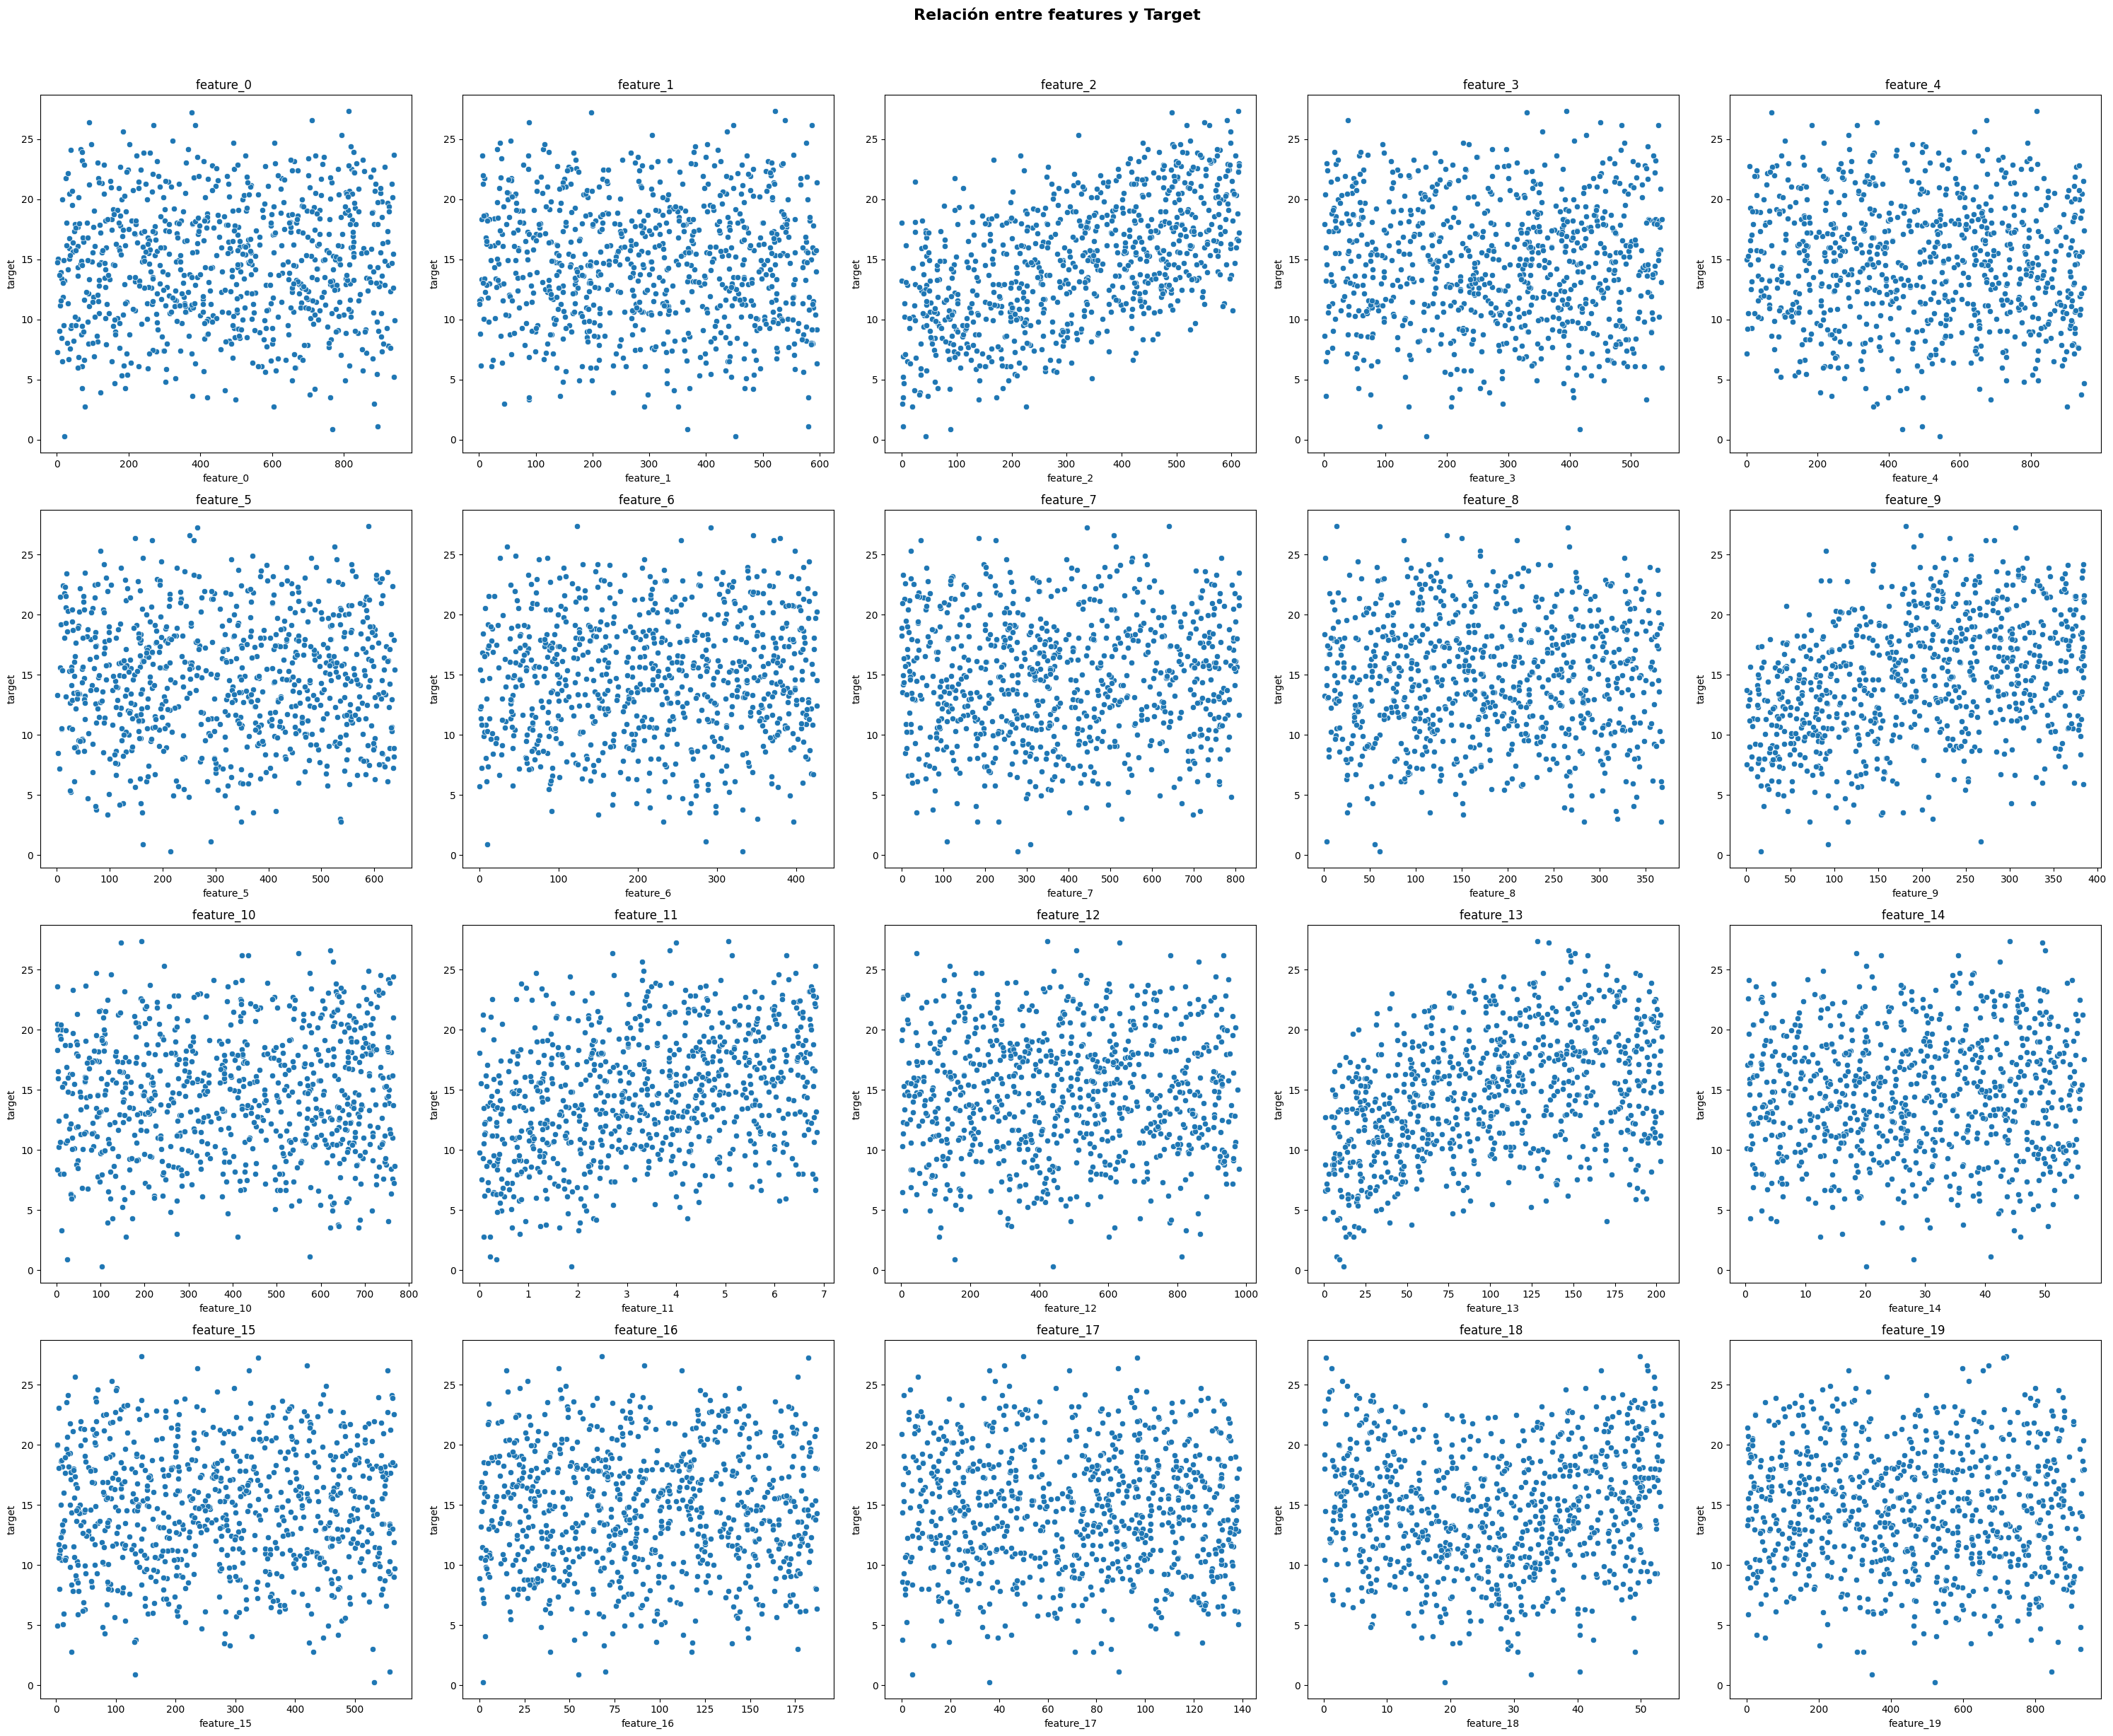

In [5]:
# Relationship between features and target variable.

# Setting up the graph
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(30, 25))
fig.suptitle("Relación entre features y Target", fontsize=16, fontweight="bold")
axes = axes.flatten()

# Creating scatter plots to show the relation between features and target
for i, col in enumerate(df.drop(columns=["target"]).columns):
    sns.scatterplot(x=df[col], y=df["target"], ax=axes[i])
    axes[i].set_title(f"{col} ")

# Adjusting layout and displaying the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


I completed this analysis by calculating the Pearson correlation between the features and the target variable. As shown in the heatmap, most features have a weak correlation with the target. Only 4 variables has a stronger correlation, between 0.32 and 0.55.

This analysis helps us to understand the explanatory power when we modeling the target varaible.

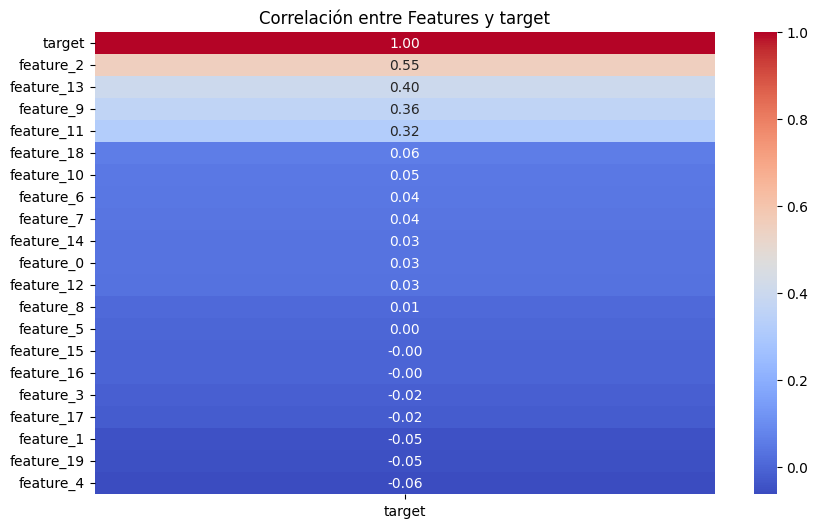

In [6]:
# Calculating correlation just between the features and the target
correlation = df.corr()
correlation = correlation[['target']]
correlation.sort_values(by='target',ascending=False, inplace=True)

#Displaying the plot
plt.figure(figsize=(10, 6))
sns.heatmap(correlation[['target']], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre Features y target")
plt.show()

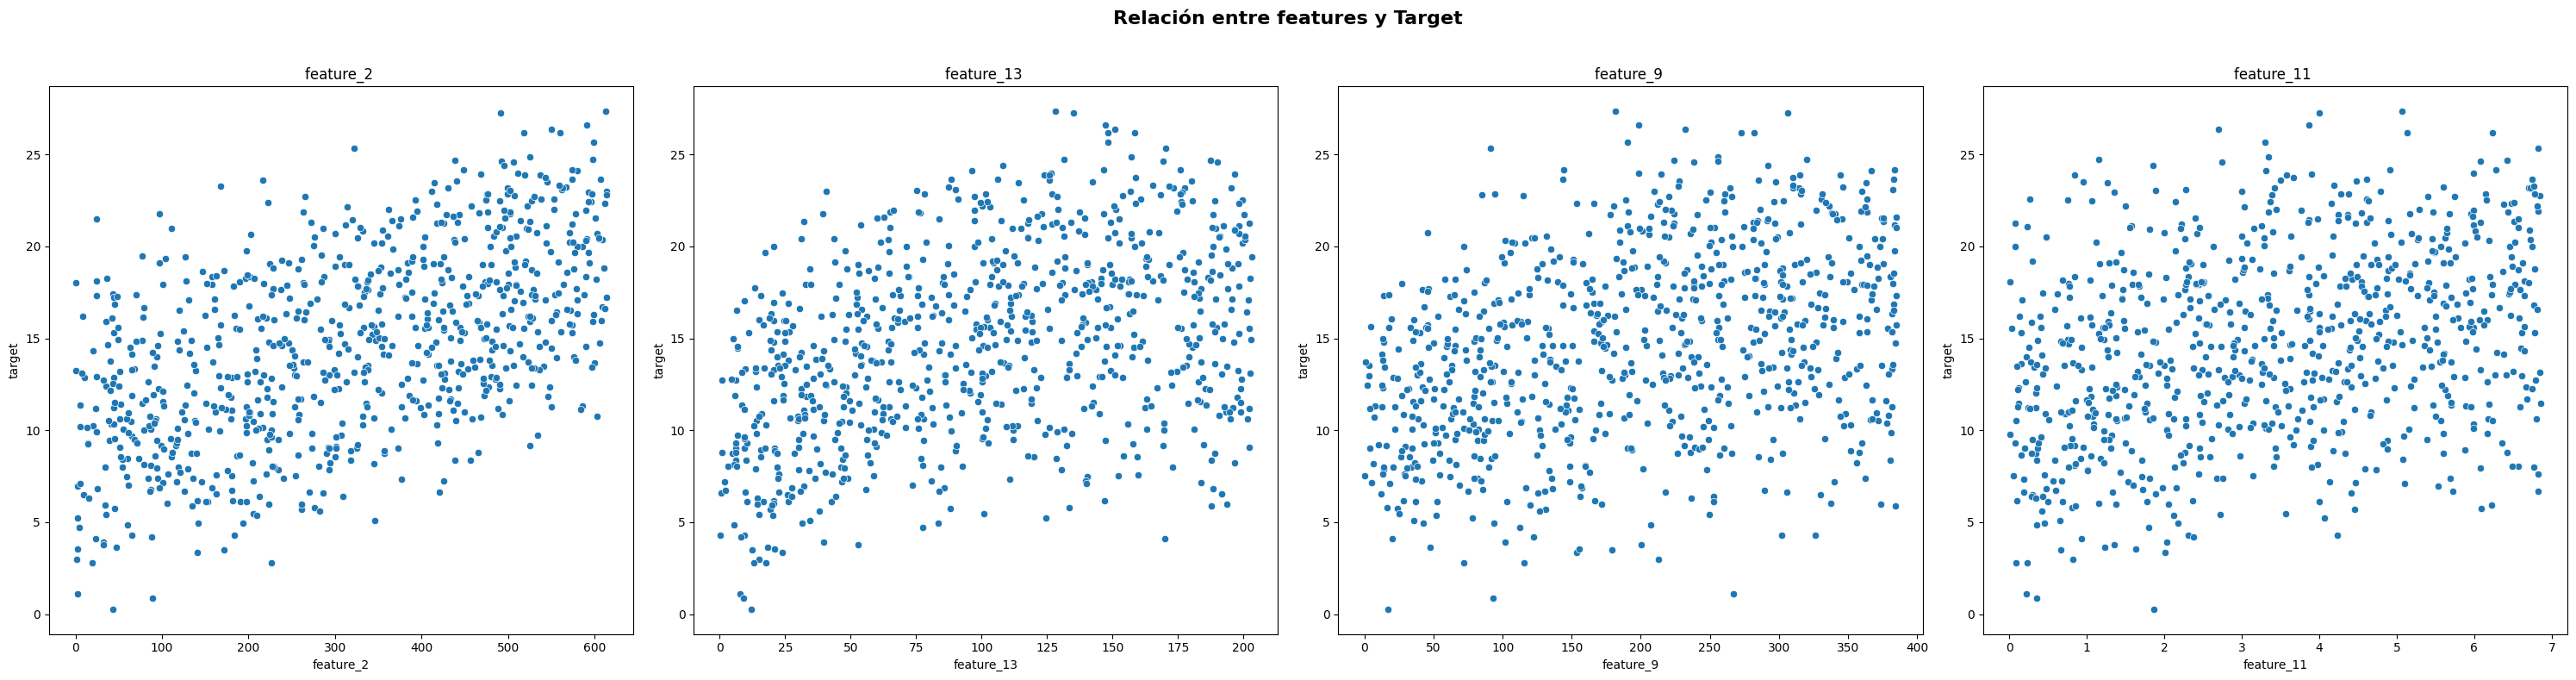

In [7]:
# Displaying the four variables with the stronger correlation with the target.

# Setting up the figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 8))
fig.suptitle("Relación entre features y Target", fontsize=16, fontweight="bold")
axes = axes.flatten()
# Selecting the features with the highest correlation
main_cols = ['feature_2','feature_13' ,'feature_9','feature_11']
# Creating scatter plots to show the relation between features and target
for i, col in enumerate(df[main_cols].columns):
    sns.scatterplot(x=df[col], y=df["target"], ax=axes[i])
    axes[i].set_title(f"{col} ")
# Adjusting layout and displaying the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In the graphs, we can observe a linear trend between the features and the target, which explains the correlation values. However, these features don't exhibit a strong relationship with the target, although their distribution is approximately linear.

Now, it's important to find relationships between the features, but in this case they have a weak relationship, close to 0.

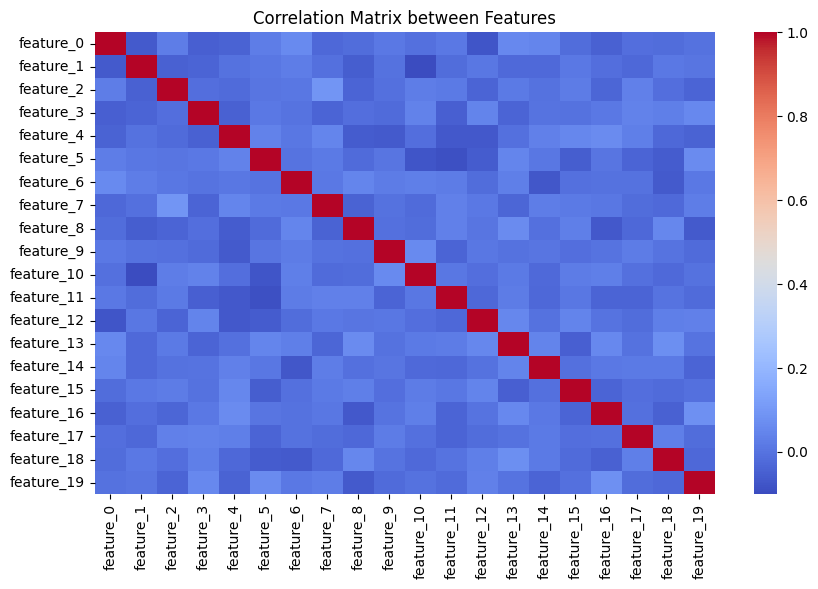

In [8]:
# Correlation Matrix between Features
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns='target').corr(), cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix between Features")
plt.show()

# Modelos

As described in the exercise, the data hasn't outliers or null values, so data cleaning is not required. Based on the analysis shown, we can proceed with modeling the data.

To efficiently manage training and testing data, I created the Dataset class, which store both feature (X) and target (y) variables for training and testing.

Create_dataset() function. This function takes raw data, splits it into training and testing sets using train_test_split, and returns a Dataset. 

Additionally, I developed the metrics() function to evaluate regresion machine learning models. It computes performance metrics, for both training and testing sets. It also includes cross-validation (cross_val_score) to assess model generalization. The results are stored in a DataFrame, allowing for easy comparison across different models.

In [ ]:
class Dataset:
    def __init__(self, X_train, y_train, X_test, y_test):
        """Store training and testing datasets"""
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

def create_dataset(X, y, test_size: float = 0.25, random_state: float = 42):
    """Function for Split data and create a dataset"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return Dataset(X_train, y_train, X_test, y_test)

def metrics(df: pd.DataFrame, model_name: str, model, dataset, cv: int = 5) -> pd.DataFrame:
    """Calculating metrics for regression models"""
    # Predictions
    y_train_pred = model.predict(dataset.X_train)
    y_test_pred = model.predict(dataset.X_test)

    # Metrics for train and test to evaluate overfitting
    train_mae = mean_absolute_error(dataset.y_train, y_train_pred)
    test_mae = mean_absolute_error(dataset.y_test, y_test_pred)

    train_mse = mean_squared_error(dataset.y_train, y_train_pred)
    test_mse = mean_squared_error(dataset.y_test, y_test_pred)

    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    train_r2 = r2_score(dataset.y_train, y_train_pred)
    test_r2 = r2_score(dataset.y_test, y_test_pred)

    train_mape = mean_absolute_percentage_error(dataset.y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(dataset.y_test, y_test_pred)

    # Cross validation with R2
    cross_val_r2 = np.mean(cross_val_score(model, dataset.X_train, dataset.y_train, cv=cv, scoring='r2'))

    # Row with metrics for 1 model
    new_row = pd.DataFrame([{
        "Model": model_name,
        "Train MAE": train_mae,
        "Test MAE": test_mae,
        "Train MSE": train_mse,
        "Test MSE": test_mse,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Train R2": train_r2,
        "Test R2": test_r2,
        "Train MAPE": train_mape,
        "Test MAPE": test_mape,
        "Cross Val R2": cross_val_r2
    }])
    # Adding the new row to existing dataframe
    return pd.concat([df, new_row], ignore_index=True)

#Empty dataframe to store metrics
df_metrics = pd.DataFrame()

The models considered in this section are: Linear Regression, XGB, L, Ridge, Random Forest Regressor and LGBM.

For modeling the behavior of the data, I considered three approaches:
1. Using all available variables.
2. Selecting only the most correlated variables and dropping those with a weak relationship with the target.
3. Excluding the variable with the strongest correlation to analyze its impact on model performance.

These different approaches allow us to explore how feature selection affects model accuracy and generalization. The models considered in this section are: Linear Regression, XGBoost (XGB), Ridge, Random Forest Regressor, and LightGBM (LGBM)

In [ ]:
# Datasets based on the approaches:
subsets = {
    "all": df.drop(columns="target"), #Using all available variables.
    "main": df[['feature_2', 'feature_9', 'feature_11', 'feature_13']], #The most correlated variables
    "ef2": df.drop(columns="feature_2"), #Excluding the variable with the strongest correlation
}

# Target varaible
y = df["target"]

# Creating train and test datasets
datasets = {name: create_dataset(X, y) for name, X in subsets.items()}

In [ ]:
# Regresion Linear
for data in datasets.keys():
    #Creating model
    model = LinearRegression()
    #Training model
    model.fit(datasets[data].X_train, datasets[data].y_train)
    #Making predictions and calcularing metrics
    df_metrics = metrics(df_metrics, f"LinearRegression_{data} ", model, datasets[data])

In [12]:
# Initialize an XGBRegressor model with a squared error objective
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Hyperparameter grid definition for tuning
param_grid = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [3, 5, 7],  
    'subsample': [0.7, 0.8, 1.0],  
    'colsample_bytree': [0.7, 0.8, 1.0]  
}

# Store in a Dictonary GridSearchCV results and the best models
grid_search_results = {}
best_xgb_models = {}

# GridSearchCV for each dataset
for key in ['all', 'main', 'ef2']:
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='r2',  
        cv=5,  
        verbose=1,  
        n_jobs=-1  
    )
    # Training
    grid_search.fit(datasets[key].X_train, datasets[key].y_train)
    
    #  Store the grid search results and the best model found
    grid_search_results[key] = grid_search
    best_xgb_models[key] = grid_search.best_estimator_

# Calculating metrics for each models
for key, model in best_xgb_models.items():
    df_metrics = metrics(df_metrics, f"Xgb_{key}", model, datasets[key])

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [13]:
#Random Forest Regressor

# Store in a Dictonary GridSearchCV results and the best models
grid_search_rf_results = {}
best_rf_models = {}

# Hyperparameter grid definition for tuning
rf_param_grid = {
    'n_estimators': [100, 300, 500],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt']  
}

# GridSearchCV for each dataset
for key in datasets.keys():
    rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)  
    
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=rf_param_grid,
        scoring='r2',  
        cv=5,  
        verbose=1, 
        n_jobs=-1  
    )
    # Train the model 
    grid_search.fit(datasets[key].X_train, datasets[key].y_train)
    
    # Store the grid search results and the best model found
    grid_search_rf_results[key] = grid_search
    best_rf_models[key] = grid_search.best_estimator_

# Calculating metrics for each models
for key, model in best_rf_models.items():
    df_metrics = metrics(df_metrics, f"RandomForestR_{key}", model, datasets[key])


Fitting 5 folds for each of 162 candidates, totalling 810 fits


/Users/sharoncamacho/anaconda3/envs/wiz2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
142 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sharoncamacho/anaconda3/envs/wiz2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sharoncamacho/anaconda3/envs/wiz2/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/shar

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/Users/sharoncamacho/anaconda3/envs/wiz2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
213 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sharoncamacho/anaconda3/envs/wiz2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sharoncamacho/anaconda3/envs/wiz2/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/shar

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/Users/sharoncamacho/anaconda3/envs/wiz2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
193 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sharoncamacho/anaconda3/envs/wiz2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sharoncamacho/anaconda3/envs/wiz2/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/shar

In [14]:
# Ridge

# Store in a Dictonary GridSearchCV results and the best models
grid_search_ridge_results = {}
best_ridge_models = {}

# Hyperparameter grid definition for tuning
ridge_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  
}

# GridSearchCV for each dataset
for key in datasets.keys():
    ridge = Ridge()  
    
    grid_search = GridSearchCV(
        estimator=ridge,
        param_grid=ridge_param_grid,
        scoring='r2',  
        cv=5,  
        verbose=1,  #
        n_jobs=-1 
    )
    # Train the model 
    grid_search.fit(datasets[key].X_train, datasets[key].y_train)
    # Store the grid search results and the best model found
    grid_search_ridge_results[key] = grid_search
    best_ridge_models[key] = grid_search.best_estimator_

# Calcularing metrics for each models
for key, model in best_ridge_models.items():
    df_metrics = metrics(df_metrics, f"Ridge_{key}", model, datasets[key])


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [19]:
for data in datasets.keys():
    # Creating the model
    lgb_model = LGBMRegressor(num_leaves=31,learning_rate=0.1,n_estimators=100,reg_alpha=0,reg_lambda=0)
    # Training the model
    lgb_model.fit(datasets[data].X_train, datasets[data].y_train)
    #Making the prediction and calcuating the metrics.
    df_metrics = metrics(df_metrics, f"LGBMRegressor_{data} ", lgb_model, datasets[data])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4020
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 20
[LightGBM] [Info] Start training from score 14.467837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [20]:
#General Results
df_metrics

,Model,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R2,Test R2,Train MAPE,Test MAPE,Cross Val R2
0,LinearRegression_all,2.154238e+00,2.124266e+00,7.860837e+00,7.055675e+00,2.803718e+00,2.656252e+00,0.705994,0.692575,2.057329e-01,1.578010e-01,0.679880
1,LinearRegression_main,2.179552e+00,2.091139e+00,8.065848e+00,7.029549e+00,2.840044e+00,2.651330e+00,0.698326,0.693713,2.088477e-01,1.565003e-01,0.691387
2,LinearRegression_ef2,4.275746e-15,4.067857e-15,3.009474e-29,2.767324e-29,5.485867e-15,5.260536e-15,1.000000,1.000000,3.853364e-16,2.971888e-16,1.000000
3,Xgb_all,6.430821e-01,1.583626e+00,6.857002e-01,3.957343e+00,8.280702e-01,1.989307e+00,0.974354,0.827573,5.845287e-02,1.217512e-01,0.837429
4,Xgb_main,1.330578e+00,1.974446e+00,2.756884e+00,5.587669e+00,1.660387e+00,2.363825e+00,0.896889,0.756538,1.208092e-01,1.479194e-01,0.769865
5,Xgb_ef2,3.286300e-03,4.373482e-02,2.023271e-05,4.844990e-03,4.498078e-03,6.960596e-02,0.999999,0.999789,4.495036e-04,3.267727e-03,0.999397
6,RandomForestR_all,8.676885e-01,2.321614e+00,1.147476e+00,8.016085e+00,1.071203e+00,2.831269e+00,0.957083,0.650728,9.885139e-02,1.828705e-01,0.665591
7,RandomForestR_main,1.087700e+00,2.061555e+00,1.951872e+00,6.247639e+00,1.397094e+00,2.499528e+00,0.926997,0.727782,1.141642e-01,1.554696e-01,0.742923
8,RandomForestR_ef2,3.816401e-01,9.054082e-01,3.123483e-01,1.572820e+00,5.588813e-01,1.254121e+00,0.988318,0.931470,5.548587e-02,7.338451e-02,0.907491
9,Ridge_all,2.153751e+00,2.123707e+00,7.865405e+00,7.056148e+00,2.804533e+00,2.656341e+00,0.705823,0.692554,2.066371e-01,1.576395e-01,0.679976


For improving the analysis, I split the model name to distinguish the three approaches: using all variables (all), using only the most correlated variables (main), and excluding the variable with the highest correlation (ef2)

In [21]:
df_metrics['type'] = df_metrics['Model'].str.split('_', expand=True)[1]
df_metrics = df_metrics.sort_values(by='type')
df_metrics

,Model,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R2,Test R2,Train MAPE,Test MAPE,Cross Val R2,type
3,Xgb_all,6.430821e-01,1.583626e+00,6.857002e-01,3.957343e+00,8.280702e-01,1.989307e+00,0.974354,0.827573,5.845287e-02,1.217512e-01,0.837429,all
6,RandomForestR_all,8.676885e-01,2.321614e+00,1.147476e+00,8.016085e+00,1.071203e+00,2.831269e+00,0.957083,0.650728,9.885139e-02,1.828705e-01,0.665591,all
9,Ridge_all,2.153751e+00,2.123707e+00,7.865405e+00,7.056148e+00,2.804533e+00,2.656341e+00,0.705823,0.692554,2.066371e-01,1.576395e-01,0.679976,all
0,LinearRegression_all,2.154238e+00,2.124266e+00,7.860837e+00,7.055675e+00,2.803718e+00,2.656252e+00,0.705994,0.692575,2.057329e-01,1.578010e-01,0.679880,all
12,LGBMRegressor_all,2.524744e-01,1.581930e+00,1.144558e-01,3.977760e+00,3.383131e-01,1.994432e+00,0.995719,0.826684,2.635019e-02,1.203963e-01,0.813747,all
5,Xgb_ef2,3.286300e-03,4.373482e-02,2.023271e-05,4.844990e-03,4.498078e-03,6.960596e-02,0.999999,0.999789,4.495036e-04,3.267727e-03,0.999397,ef2
8,RandomForestR_ef2,3.816401e-01,9.054082e-01,3.123483e-01,1.572820e+00,5.588813e-01,1.254121e+00,0.988318,0.931470,5.548587e-02,7.338451e-02,0.907491,ef2
11,Ridge_ef2,3.431490e-06,3.338535e-06,1.789620e-11,1.670143e-11,4.230390e-06,4.086739e-06,1.000000,1.000000,3.632727e-07,2.537274e-07,1.000000,ef2
2,LinearRegression_ef2,4.275746e-15,4.067857e-15,3.009474e-29,2.767324e-29,5.485867e-15,5.260536e-15,1.000000,1.000000,3.853364e-16,2.971888e-16,1.000000,ef2
14,LGBMRegressor_ef2,6.961862e-02,1.051526e-01,4.658410e-02,5.085402e-02,2.158335e-01,2.255084e-01,0.998258,0.997784,2.560129e-02,8.259458e-03,0.993620,ef2


The models using the that that exclude the feature 2 (ef2) presents overfitting so I don't considered it. I also gonnta to identify overfitting and differences between R2 in train and test.

In [ ]:
df_metrics = df_metrics[df_metrics['type'].str.strip() != 'ef2']
df_metrics['sobreajuste'] = df_metrics['Test MSE'] > df_metrics['Train MSE']
df_metrics['dif_sobrAj_r2'] = df_metrics['Train R2'] - df_metrics['Test R2']
df_metrics = df_metrics.drop(columns=['Train MSE','Test MSE'])

The models that exclude feature 2 (ef2) exhibit overfitting, so I didn't consider them. I also wanna identify overfitting by analyzing the differences between R2 scores in training and testing, and another metrics like MAE and RMSE.

In [44]:
df_metrics.sort_values(by='Test R2', ascending=False)

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2,Train MAPE,Test MAPE,Cross Val R2,type,sobreajuste,dif_sobrAj_r2
3,Xgb_all,0.643082,1.583626,0.828070,1.989307,0.974354,0.827573,0.058453,0.121751,0.837429,all,True,0.146781
12,LGBMRegressor_all,0.252474,1.581930,0.338313,1.994432,0.995719,0.826684,0.026350,0.120396,0.813747,all,True,0.169036
4,Xgb_main,1.330578,1.974446,1.660387,2.363825,0.896889,0.756538,0.120809,0.147919,0.769865,main,True,0.140351
13,LGBMRegressor_main,0.856238,2.035646,1.057732,2.444542,0.958155,0.739627,0.088103,0.152723,0.756680,main,True,0.218529
7,RandomForestR_main,1.087700,2.061555,1.397094,2.499528,0.926997,0.727782,0.114164,0.155470,0.742923,main,True,0.199215
10,Ridge_main,2.179631,2.090932,2.840052,2.651303,0.698325,0.693719,0.208941,0.156472,0.691391,main,False,0.004605
1,LinearRegression_main,2.179552,2.091139,2.840044,2.651330,0.698326,0.693713,0.208848,0.156500,0.691387,main,False,0.004613
0,LinearRegression_all,2.154238,2.124266,2.803718,2.656252,0.705994,0.692575,0.205733,0.157801,0.679880,all,False,0.013419
9,Ridge_all,2.153751,2.123707,2.804533,2.656341,0.705823,0.692554,0.206637,0.157640,0.679976,all,False,0.013269
6,RandomForestR_all,0.867688,2.321614,1.071203,2.831269,0.957083,0.650728,0.098851,0.182870,0.665591,all,True,0.306355


Although XGB and LGBM show some overfitting, these models have lower error compared to others. Despite this difference, they can still generalize the results better.

Therefore, I looked for optimal hyperparameters and saved the model.

In [66]:
best_xgb_models['all']

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [62]:
joblib.dump(best_xgb_models['all'], "modelo_xgb.pkl")
print("Modelo guardado correctamente.")

Modelo guardado correctamente.


# Best Models Prediction Blid Data

Just for testing the blind data, I tried to find a similar distribution of the predictions in the blind data compared to the provided training data. In this case, although Ridge and Simple Linear Regression have a slight right skew, XGB and LGBM replicate the normal tendency of the predictions.

In [47]:
test = pd.read_csv("../data/blind_test_data.csv")

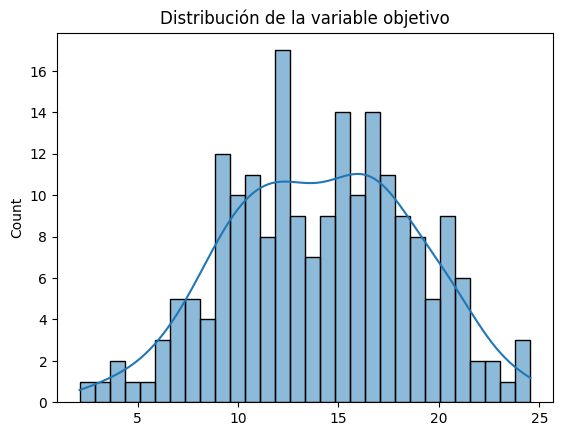

In [49]:
# XGB
y_pred_blind = best_xgb_models['all'].predict(test)
sns.histplot(y_pred_blind, bins=30, kde=True)
plt.title("Distribución de la variable objetivo")
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4020
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 20
[LightGBM] [Info] Start training from score 14.467837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

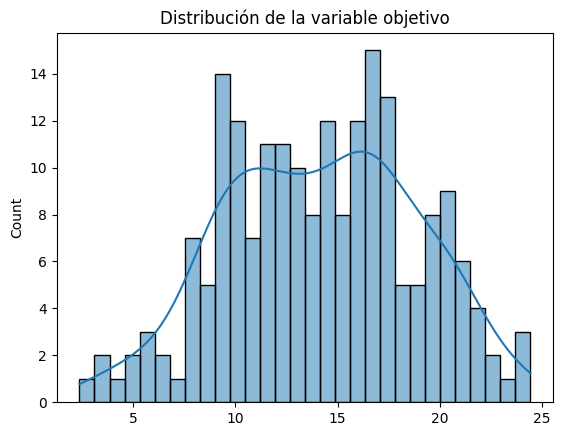

In [61]:
#LGBMRegressor
lgb_model = LGBMRegressor(num_leaves=31,learning_rate=0.1,n_estimators=100,reg_alpha=0,reg_lambda=0)
lgb_model.fit(datasets['all'].X_train, datasets['all'].y_train)
y_pred_blind = lgb_model.predict(test)
sns.histplot(y_pred_blind, bins=30, kde=True)
plt.title("Distribución de la variable objetivo")
plt.show();

In [52]:
best_ridge_models['main']

Ridge(alpha=10)

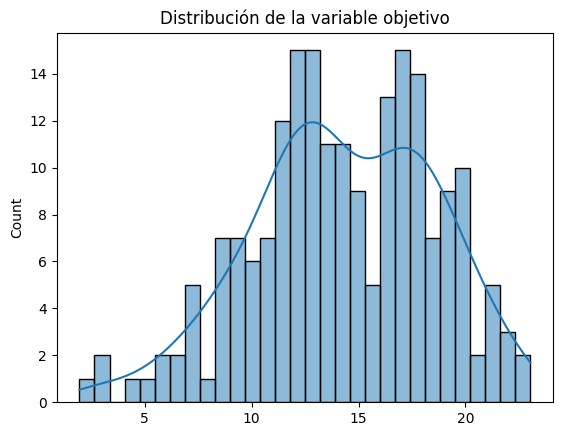

In [57]:
y_pred_blind = best_ridge_models['main'].predict(test[['feature_2', 'feature_9', 'feature_11', 'feature_13']])
#Revisión de la distribución de la variable objetivo
sns.histplot(y_pred_blind, bins=30, kde=True)
plt.title("Distribución de la variable objetivo")
plt.show()

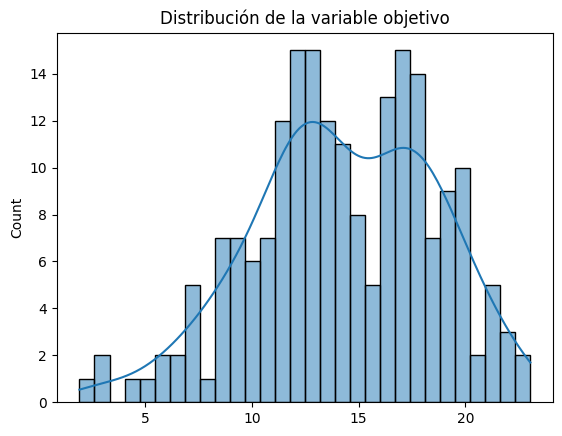

In [58]:
model = LinearRegression()
model.fit(datasets['main'].X_train, datasets['main'].y_train)
y_pred_blind = model.predict(test[['feature_2', 'feature_9', 'feature_11', 'feature_13']])
#Revisión de la distribución de la variable objetivo
sns.histplot(y_pred_blind, bins=30, kde=True)
plt.title("Distribución de la variable objetivo")
plt.show()